In [28]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.convolution

import pandas as pd

In [29]:
def centroid(image_cutout, start_x, start_y):
    
    x_size, y_size = image_cutout.shape
    xx, yy = np.meshgrid(np.arange(start_x, start_x + x_size),
                         np.arange(start_y, start_y + y_size))
    
    x_center = np.sum(image_cutout*xx) / np.sum(image_cutout)
    y_center = np.sum(image_cutout*yy) / np.sum(image_cutout)
    
    return (x_center, y_center)

In [30]:
def gaussian2D(radius, mu):
    
    return 1 / ( mu**2*2*np.pi ) * np.exp( -0.5 * ( ( radius ) / mu )**2 )

In [31]:
def psf_gaussian_flux(image_cutout, centroid_x, centroid_y, radius, start_x, start_y):    
    
    x_size, y_size = image_cutout.shape
    xx, yy = np.meshgrid( np.arange(start_x, start_x + x_size ),
                          np.arange(start_y, start_y + y_size ) )
    
    r = np.sqrt( (xx - centroid_x)**2 + (yy - centroid_y)**2 )
    
    psf_image = gaussian2D( r, radius )
    psf_flux = np.sum( psf_image * cutout ) / np.sum( psf_image**2 )
    
    return psf_flux

In [32]:
def find_peaks(image, threshold):
    
    peak_x_values = [] 
    peak_y_values = []
    edgewidth = 5
    
    for i in range(edgewidth, image.shape[0] - edgewidth):
        for j in range(edgewidth, image.shape[1] - edgewidth):
            pixel = image[i,j]
            if(pixel < threshold):
                continue
            if(pixel > image[i + 1, j] and               
               pixel > image[i - 1, j] and
               pixel > image[i , j + 1] and
               pixel > image[i , j - 1] and
               pixel > image[i + 1, j - 1] and
               pixel > image[i - 1, j + 1] and
               pixel > image[i - 1, j - 1] and
               pixel > image[i + 1, j + 1]):
                peak_x_values.append(i)
                peak_y_values.append(j)
                
    return np.array(peak_x_values), np.array(peak_y_values)

In [33]:
def run_photometry(image, threshold, psf_width):
    
    convolved_image = astropy.convolution.convolve(image, astropy.convolution.Gaussian2DKernel(2.6))

    peak_xs, peak_ys = find_peaks(convolved_image, threshold)
    
    moments_x = []
    moments_y = []
    centroids_x = []
    centroids_y = []
    fluxes = []
    
    for peak_x, peak_y in zip(peak_xs, peak_ys):
        
        image_cutout = image[(peak_x - 5):(peak_x + 5), (peak_y - 5):(peak_y + 5)]
        start_x = int(peak_x - 5)
        start_y = int(peak_y - 5)

        centroid_x, centroid_y = centroid(image_cutout, peak_x, peak_y)
        centroids_x.append(centroid_x)
        centroids_y.append(centroid_y)

        moment_x, moment_y = second_moment_estimate(image_cutout, peak_x, peak_y, start_x, start_y)
        moments_x.append(moment_x)
        moments_y.append(moment_y)

        psf_flux = psf_gaussian_flux(image_cutout, centroid_x, centroid_y, psf_width, start_x, start_y)
        fluxes.append(psf_flux)
        
    return pd.DataFrame({"centroid_x": centroids_x,
                         "centroid_y": centroids_y,
                         "moment_x": moments_x,
                         "moment_y": moments_y,
                         "gaussian_flux": fluxes})
    

In [34]:
def second_moment_estimate(image_cutout, centroid_x, centroid_y, start_x, start_y):
    
    x_size, y_size = image_cutout.shape
    xx, yy = np.meshgrid(np.arange(start_x, start_x + x_size),
                         np.arange(start_y, start_y + y_size))
    
    x_width = np.sqrt(np.sum( (image_cutout * (xx - centroid_x))**2) ) / np.sqrt(np.sum( image_cutout**2 ) )
    y_width = np.sqrt(np.sum( (image_cutout * (yy - centroid_y))**2) ) / np.sqrt( np.sum(image_cutout**2 ) )
    
    return (x_width, y_width)

C:\Users\Luke\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


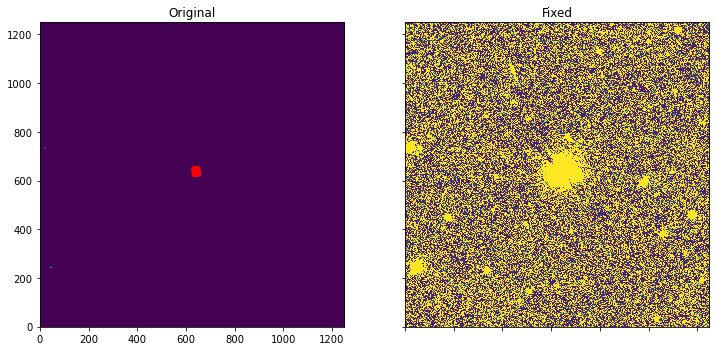

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans


filename = get_pkg_data_filename('T crb g.fits')

hdu = fits.open(filename)[0]
img = hdu.data[0:1250, 0:1250]


img[img < 0] = 0


kernel = Gaussian2DKernel(x_stddev=5)


fixed_image = interpolate_replace_nans(img, kernel)


plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) 

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(img, origin='lower', interpolation='nearest', cmap='viridis')
y, x = np.where(np.isnan(img))

ax1.plot(x, y, 'rx', markersize=4)
ax1.set_title("Original")


ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(fixed_image, vmin=-2., vmax=2.e1, origin='lower', interpolation='nearest', cmap='viridis')
ax2.set_title("Fixed")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#plt.savefig('Original Aperture and Interpolated images')

image = fixed_image

Text(0.5, 1.0, "'Fixed'")

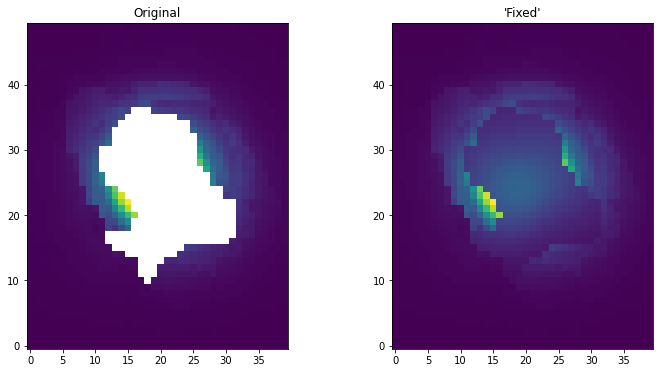

In [36]:
f = fits.open("T crb g.fits")
image_sat = f[0].data

cutout_sat = image_sat[615:665, 620:660]

cutout = image[615:665, 620:660]

plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) 

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(cutout_sat, origin='lower', interpolation='nearest', cmap='viridis')
y, x = np.where(np.isnan(img))

#ax1.plot(x, y, 'rx', markersize=4)
ax1.set_title("Original")


ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(cutout, origin='lower', interpolation='nearest', cmap='viridis')
ax2.set_title("'Fixed'")

#plt.savefig('Original Aperture and Interpolated image cutouts')

In [37]:
xx, yy = np.meshgrid(range(2, 10), range(40, 50))
print("xx: ", xx)
print("yy: ", yy)

xx:  [[2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]]
yy:  [[40 40 40 40 40 40 40 40]
 [41 41 41 41 41 41 41 41]
 [42 42 42 42 42 42 42 42]
 [43 43 43 43 43 43 43 43]
 [44 44 44 44 44 44 44 44]
 [45 45 45 45 45 45 45 45]
 [46 46 46 46 46 46 46 46]
 [47 47 47 47 47 47 47 47]
 [48 48 48 48 48 48 48 48]
 [49 49 49 49 49 49 49 49]]


In [38]:
xx, yy = np.meshgrid(np.arange(0, 40), np.arange(0, 50))


In [39]:
x_center = np.sum(cutout*xx) / np.sum(cutout)
y_center = np.sum(cutout*yy) / np.sum(cutout)

print(x_center, y_center)

19.93527188592919 26.04553485332684


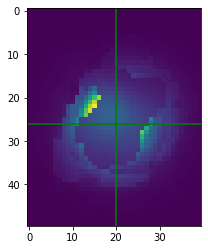

In [40]:
plt.imshow(cutout)
plt.axvline(x_center, color='g')
plt.axhline(y_center, color='g')

Text(0.5, 1.0, 'Orginal PSF estimation using pixel size = 2.5')

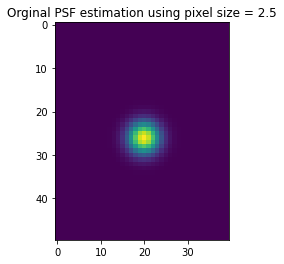

In [41]:
radius = np.sqrt( (xx - x_center)**2 + (yy - y_center)**2 )

psf_size_pixels = 2.5
psf_image = gaussian2D(radius, psf_size_pixels)
plt.imshow(psf_image)
plt.title('Orginal PSF estimation using pixel size = 2.5')
#plt.savefig('Original estimation')

In [42]:
np.sum(psf_image)

0.9999999999999981

In [43]:
psf_flux = np.sum(psf_image * cutout) / np.sum(psf_image**2)
print(psf_flux)

20824378.623685647


In [44]:
aperture_flux = np.sum(cutout)
print(aperture_flux)


137520900.0


In [45]:
##This is quite a ways off the original aperture flux, this is because of an incorrect PSF model##

In [46]:
%%time
convolved_image = astropy.convolution.convolve(image, astropy.convolution.Gaussian2DKernel(2.5))
peak_x_values, peak_y_values = find_peaks(convolved_image, 250)

Wall time: 2.82 s


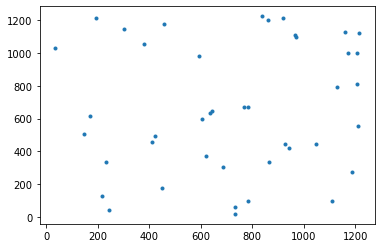

In [47]:
plt.plot(peak_x_values, peak_y_values, '.')

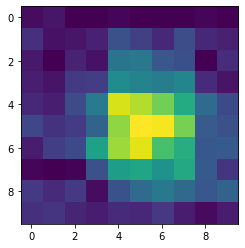

In [48]:
n = 40
peak_x = peak_x_values[n]
peak_y = peak_y_values[n]
cutout = image[(peak_x - 5):(peak_x + 5), (peak_y - 5):(peak_y + 5)]

plt.imshow(cutout)

In [49]:
median_moment = 2.5

photometry_table = run_photometry(image, 50, median_moment)

print(photometry_table[:40])

    centroid_x   centroid_y  moment_x  moment_y  gaussian_flux
0    10.069508   148.653494  2.383589  2.279146   30228.824621
1     9.613834   190.975813  2.824377  2.748850   28395.864635
2     9.797646  1176.713016  2.533385  2.444992   29362.603973
3    10.965792   240.431666  2.355608  2.761033   29543.322397
4    10.806224   499.723127  2.372967  2.557842   29406.616923
5    10.701138  1165.240606  2.240494  2.301274   30464.164371
6    11.368034   176.064801  2.670250  2.729510   27926.051325
7    11.883999   229.338315  2.415470  2.132937   29189.218211
8    11.695753   245.455849  3.055237  2.823875   28734.637297
9    11.729140   313.281016  2.914725  2.729139   28700.342840
10   11.916297  1090.598270  2.289086  2.577738   29566.291507
11   11.715132  1197.772843  2.730859  2.969030   29231.715835
12   11.665338  1239.579825  2.603749  2.348416   28793.842524
13   12.534593   258.429242  2.526610  2.480728   28337.222347
14   12.255209   271.315553  2.673576  2.667380   29762

In [50]:
moments_x = []
moments_y = []

print(peak_x_values)
print(peak_y_values)

[  33  147  169  192  214  232  244  302  380  410  422  447  458  593
  603  620  637  643  685  732  733  766  781  783  836  862  863  918
  925  944  965  971 1045 1109 1128 1158 1170 1187 1207 1207 1210 1215]
[1030  507  617 1216  129  335   45 1149 1055  459  493  176 1178  979
  600  373  635  646  308   59   19  672   99  668 1224 1202  334 1214
  446  418 1112 1099  443  100  793 1126 1000  276  808  998  555 1119]


In [51]:
for peak_x , peak_y in zip(peak_x_values,peak_y_values):
    
    image_cutout = image[(peak_x - 5):(peak_x + 5), (peak_y - 5):(peak_y + 5)]
    
    start_x = int(peak_x - 5)
    
    start_y = int(peak_y - 5)
    
    
    moment_x , moment_y = second_moment_estimate(image_cutout, peak_x, peak_y, start_x, start_y)
    
    moments_x.append(moment_x)
    moments_y.append(moment_y)


Text(0.5, 0, 'Pixel Width')

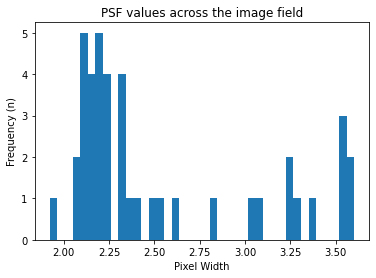

In [60]:
moments_sq = np.sqrt(np.array( moments_x )**2 + np.array( moments_y )**2)


plt.hist(moments_sq, bins=40)
plt.title('PSF values across the image field')
plt.ylabel('Frequency (n)')
plt.xlabel("Pixel Width")
#plt.savefig('PSF distribution of panSTARRS T CrB')

In [53]:
def avg_psf(array): 
    return sum(array) / len(array) 


psf = avg_psf(moments_sq)

print('The average PSF pixel width is:', avg_psf(moments_sq))

The average PSF pixel width is: 2.5415591611600425


21480768.886344645
137520900.0
There is now a much more improved accuracy of the PSF estimation: 84.37999641425792 % difference, This increase is expected as the original aperture flux did not include any saturated values!


0.9999999999999949

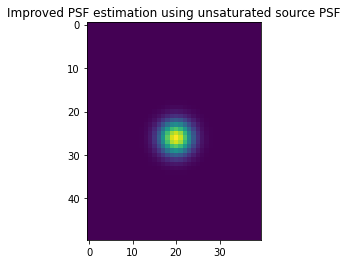

In [54]:
cutout =image[615:665, 620:660]
radius = np.sqrt((xx - x_center)**2 + (yy - y_center)**2)

psf_size_pixels = psf
psf_image_improved = gaussian2D(radius, psf_size_pixels)
plt.imshow(psf_image_improved)
plt.title('Improved PSF estimation using unsaturated source PSF')
#plt.savefig('Improved PSF estimation using unsaturated source PSF')

corrected_psf_flux = np.sum(psf_image_improved * cutout)/np.sum(psf_image_improved**2)
print(corrected_psf_flux)

aperture_flux = np.sum(cutout)
print(aperture_flux)


print('There is now a much more improved accuracy of the PSF estimation:', ((aperture_flux - corrected_psf_flux)/aperture_flux)*100,'% difference, This increase is expected as the original aperture flux did not include any saturated values!')

np.sum(psf_image_improved)